In [1]:
import orbipy as op
import numpy as np
import pandas as pd
import pickle
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)
# Earth-L1 distance:
EL1_dist = (1.0-model.mu) - model.L1
EL1_dist
# Borders
left = op.eventX(model.L1-EL1_dist)
right = op.eventX(model.L1+EL1_dist-5000/model.R)

In [3]:
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')
scaler = plotter.scaler

In [12]:
first_corr = op.border_correction(model, op.y_direction(), [left], [right])
corr = op.border_correction(model, op.unstable_direction_stm(stm_model), [left], [right])
sk = op.simple_station_keeping(precise_model, first_corr, corr, rev = np.pi/2.0)

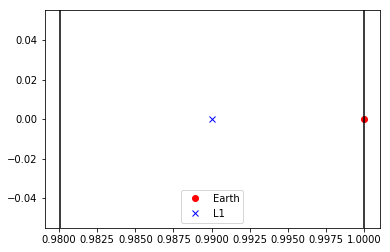

In [4]:
plt.plot(1.0-model.mu, 0.0, 'or', label='Earth')
plt.plot(model.L1, 0.0, 'xb', label='L1')
plt.axvline(model.L1-EL1_dist,c='k')
plt.axvline(model.L1+EL1_dist-5000/model.R,c='k')
plt.legend()

In [13]:
step = 10000/model.R
#zpoint = -step
zlv = 232
for i in range(5):
    zlv += 1
    zpoint = zlv*step
    xpoint = left.value
    z_row = []
    while xpoint < right.value:
        xpoint += step
        print('z level: {} km'.format(scaler(zpoint,'nd-km')))
        print('x level: {} km'.format(scaler(xpoint,'nd-km')))
        s0 = model.get_zero_state()
        s0[0] = xpoint
        s0[2] = zpoint
        try: 
            df = sk.prop(0.0, s0, N=50)
        except Exception as e:
            print('s0: ',s0)
            print(e)
        else:
            out = {}
            #out['conv'] = np.abs(np.amax(sk.dvout[:,-3:])) < 1e-4
            out['dv'] = sk.dvout[:,-3:]
            out['orbit'] = df
            z_row.append(out)
            clear_output()
    pickle.dump(z_row, open('Log/{}.bin'.format(zlv),'wb'))
print(zpoint)

z level: 2340000.0 km
x level: 148427110.2394706 km
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 

KeyboardInterrupt: 

In [14]:
fnames = glob.glob('Log/*.bin')

In [15]:
valid_stp = []
for name in fnames:
    z_row = pickle.load(open(name, 'rb'))
    for elem in z_row:
        if np.abs(elem['dv'][1:]).max() < 1e-4:
            valid_stp.append(np.array(elem['orbit'].loc[0, ['x','z']]))
valid_stp = np.array(valid_stp)

In [24]:
for name in fnames:
    z_row = pickle.load(open(name, 'rb'))
    z_row_clean = []
    for elem in z_row:
        if np.abs(elem['dv'][1:]).max() < 1e-4:
            z_row_clean.append(elem)
    pickle.dump(z_row_clean, open('LogClean/{}'.format(name.split('\\')[-1]),'wb'))

In [25]:
fnames_clean = glob.glob('LogClean/*.bin')

In [63]:
columns = ['x0','z0', 'Ax-', 'Ax+', 'Ay-', 'Ay+', 'Az-', 'Az+']
df = pd.DataFrame(columns=columns, index=np.arange(0,valid_stp.shape[0]))
df.head()

,x0,z0,Ax-,Ax+,Ay-,Ay+,Az-,Az+
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
i=0
for name in fnames_clean:
    z_row = pickle.load(open(name, 'rb'))
    for elem in z_row:
        x0, z0 = elem['orbit'].loc[0,['x','z']]
        axmin, aymin, azmin = elem['orbit'].loc[:,['x','y','z']].min()
        axmax, aymax, azmax = elem['orbit'].loc[:,['x','y','z']].max()
        df.loc[i] = [x0, z0, axmax, axmin, aymax, aymin, azmax, azmin]
        i+=1 

In [66]:
#df.to_pickle('amp.pkl')

In [89]:
#df = pd.read_pickle('amp.pkl')

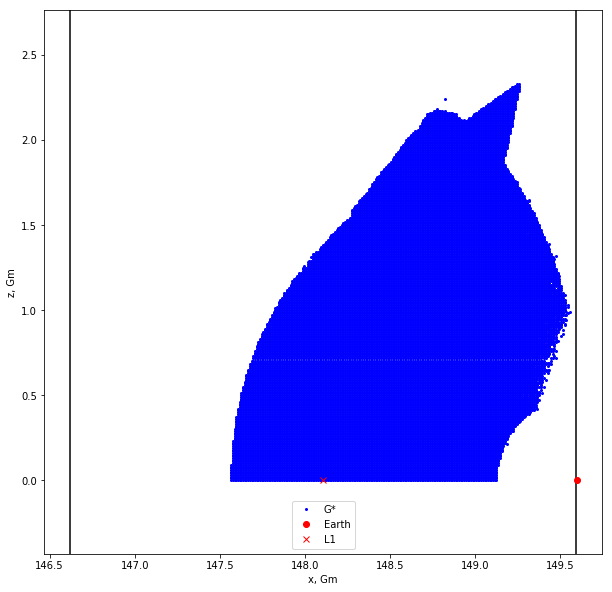

In [87]:
plt.figure(figsize=(10,10))
plt.plot(scaler(df['x0'],'nd-Gm'), scaler(df['z0'],'nd-Gm'), 'ob', markersize=2, label='G*')
plt.axvline(scaler(left.value, 'nd-Gm'),c='k')
plt.axvline(scaler(right.value, 'nd-Gm'),c='k')
plt.plot(scaler(1.0-model.mu, 'nd-Gm'), 0.0, 'or', label='Earth')
plt.plot(scaler(model.L1, 'nd-Gm'), 0.0, 'xr', label='L1')
plt.xlabel('x, Gm')
plt.ylabel('z, Gm')
plt.ylim(-10, 15000000)
plt.axis('equal')
plt.legend()
plt.savefig('area.png')

(147.46510631894756,
 149.6591141599938,
 -0.11848610191939762,
 2.4484861019193978)

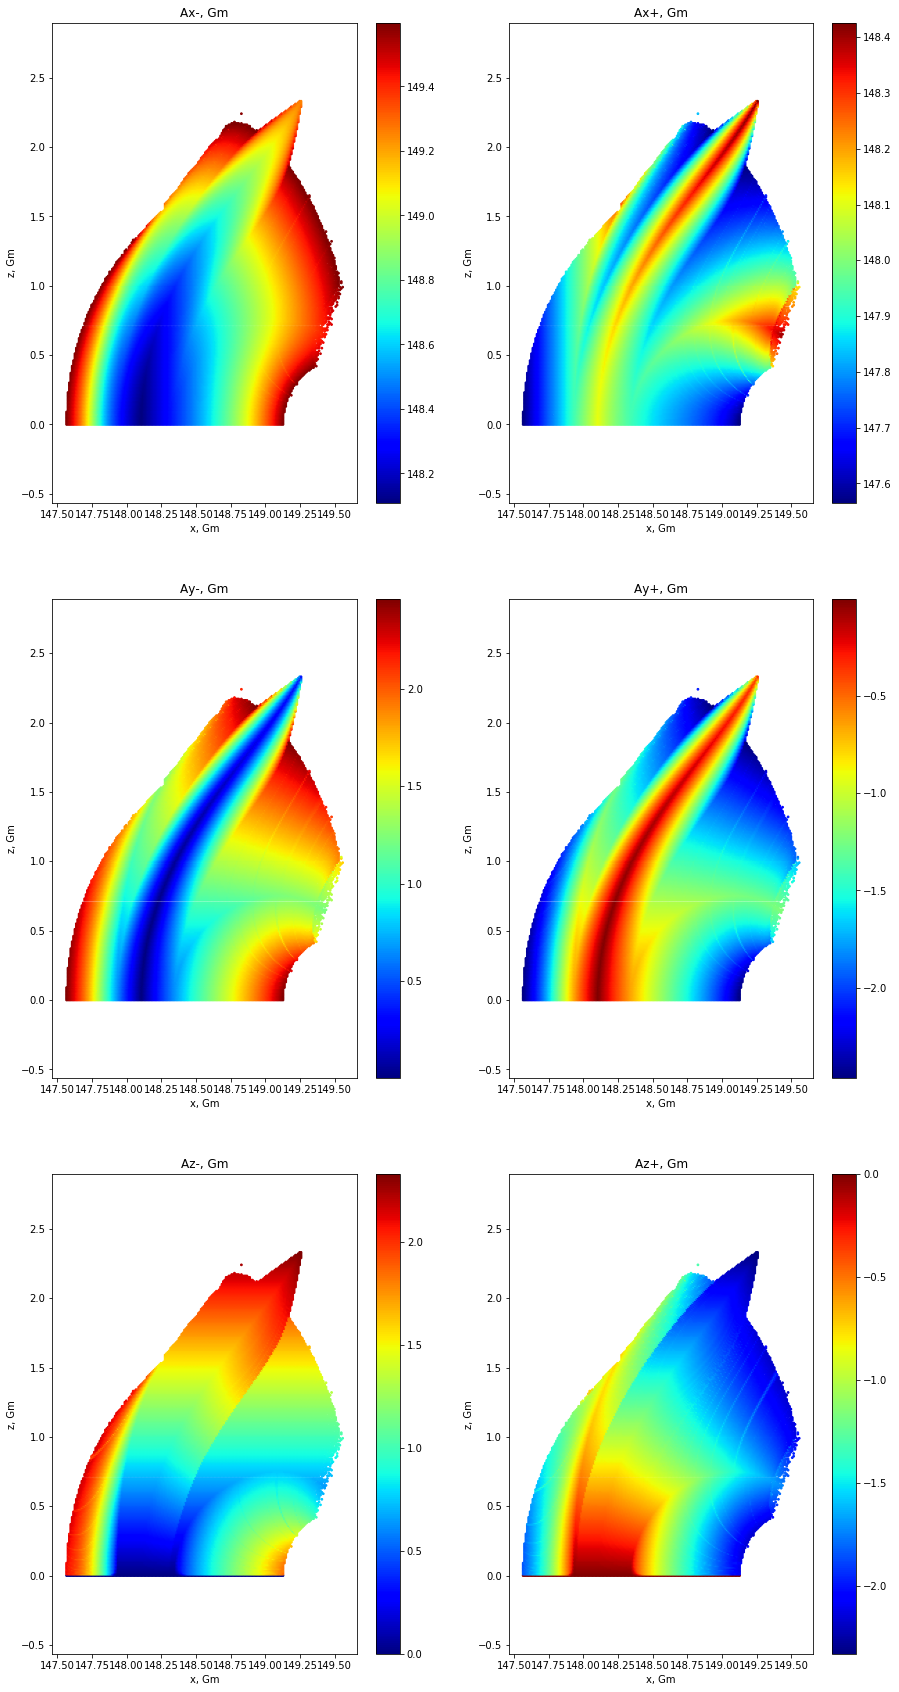

In [86]:
plt.figure(figsize=(15,30))
plt.subplot(321)
sc1 = plt.scatter(scaler(df['x0'],'nd-Gm'), scaler(df['z0'],'nd-Gm'), c=scaler(df['Ax-'],'nd-Gm'), s=3, cmap='jet')
plt.title('Ax-, Gm')
plt.xlabel('x, Gm')
plt.ylabel('z, Gm')
plt.colorbar(sc1)
plt.axis('equal')

plt.subplot(322)
sc2 = plt.scatter(scaler(df['x0'],'nd-Gm'), scaler(df['z0'],'nd-Gm'), c=scaler(df['Ax+'],'nd-Gm'), s=3, cmap='jet')
plt.title('Ax+, Gm')
plt.xlabel('x, Gm')
plt.ylabel('z, Gm')
plt.colorbar(sc2)
plt.axis('equal')

plt.subplot(323)
sc1 = plt.scatter(scaler(df['x0'],'nd-Gm'), scaler(df['z0'],'nd-Gm'), c=scaler(df['Ay-'],'nd-Gm'), s=3, cmap='jet')
plt.title('Ay-, Gm')
plt.xlabel('x, Gm')
plt.ylabel('z, Gm')
plt.colorbar(sc1)
plt.axis('equal')

plt.subplot(324)
sc2 = plt.scatter(scaler(df['x0'],'nd-Gm'), scaler(df['z0'],'nd-Gm'), c=scaler(df['Ay+'],'nd-Gm'), s=3, cmap='jet')
plt.title('Ay+, Gm')
plt.xlabel('x, Gm')
plt.ylabel('z, Gm')
plt.colorbar(sc2)
plt.axis('equal')

plt.subplot(325)
sc1 = plt.scatter(scaler(df['x0'],'nd-Gm'), scaler(df['z0'],'nd-Gm'), c=scaler(df['Az-'],'nd-Gm'), s=3, cmap='jet')
plt.title('Az-, Gm')
plt.xlabel('x, Gm')
plt.ylabel('z, Gm')
plt.colorbar(sc1)
plt.axis('equal')

plt.subplot(326)
sc2 = plt.scatter(scaler(df['x0'],'nd-Gm'), scaler(df['z0'],'nd-Gm'), c=scaler(df['Az+'],'nd-Gm'), s=3, cmap='jet')
plt.title('Az+, Gm')
plt.xlabel('x, Gm')
plt.ylabel('z, Gm')
plt.colorbar(sc2)
plt.axis('equal')

